#### **imports**

In [1]:
import pickle
import sys
from collections import Counter
from collections import OrderedDict
import torch
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.optim import Optimizer

from torch import Tensor

import torch.nn as nn
import torch.nn.functional as F
from torch.nn.modules.loss import _Loss
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import Dataset, DataLoader

import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.model_selection import ParameterGrid
from collections import OrderedDict
from collections import Counter
import shap

# Set the random seed
np.random.seed(123)
random_state = 123

# Clustering
from sklearn.cluster import KMeans

# Specify the number of clusters (K)
_clusters = 1

# Evaluation
from sksurv.metrics import concordance_index_ipcw, brier_score, cumulative_dynamic_auc

# Add the outer directory
sys.path.append('../')
from eval_surv_copy import EvalSurv

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


In [2]:
def plot_cluster_hist(arr: np.array):
    cluster_counts = Counter(arr)
    # Sort the Counter object by keys in ascending order
    sorted_countes = OrderedDict(sorted(cluster_counts.items()))
    
    # Extract the category labels and their corresponding counts
    labels = list(sorted_countes.keys())
    counts = list(sorted_countes.values())

    # Plot the histogram
    plt.bar(labels, counts);

    # Set the labels and title
    plt.xlabel('Categories')
    plt.ylabel('Counts')
    plt.title('Categorical Histogram')
    plt.xticks(labels)

    for i, value in enumerate(counts):
        plt.text(i, value + 1, str(value), ha='center', va='bottom')

    plt.show()

#### **Load Data**

In [3]:
# Read the pickled DataFrames
with open('data/x_train_reshape_tv.pickle', 'rb') as file:
    x_train_reshape_tv = pickle.load(file)
with open('data/x_test_reshape_tv.pickle', 'rb') as file:
    x_test_reshape_tv = pickle.load(file)
with open('data/x_val_reshape_tv.pickle', 'rb') as file:
    x_val_reshape_tv = pickle.load(file)

# Read the pickled targets
with open('data/y_train.pickle', 'rb') as file:
    y_train = pickle.load(file)
with open('data/y_test.pickle', 'rb') as file:
    y_test = pickle.load(file)
with open('data/y_val.pickle', 'rb') as file:
    y_val = pickle.load(file)

# Read the pickled DataFrame
with open('data/consolidated_pat_tbl_tv.pickle', 'rb') as file:
    consolidated_pat_tbl_tv = pickle.load(file)

#### **Encoding**

In [4]:
class Encoder(nn.Module):
    def __init__(self,hidden_dim: int):
        super(Encoder, self).__init__()
        self.conv1 = nn.Conv2d(1, 14, kernel_size = 3 , stride = 1 , padding = 1)
        self.conv2 = nn.Conv2d(14, 7, kernel_size = 3, stride = 1 , padding = 1)
        self.act = nn.Sigmoid()
        self.flatten = nn.Flatten()
        self.dense1 = nn.Linear(7 * 10 * 90, hidden_dim)

    def forward(self, x: Tensor) -> Tensor:
        # assert x.dim() == 4

        x = self.conv1(x)
        x = self.act(x)
        x = self.conv2(x)
        x = self.act(x)
        x = self.flatten(x)
        x = self.dense1(x)
        # x = self.act(x)
        return x

In [5]:
class Decoder(nn.Module):
    def __init__(self,hidden_dim: int):
        super(Decoder, self).__init__()
        self.dense1 = nn.Linear(hidden_dim, 7 * 10 * 90)
        self.flatten = nn.Flatten()
        self.act = nn.Sigmoid()
        self.conv1 = nn.Conv2d(7, 14, kernel_size = 3 , stride = 1 , padding = 1)
        self.conv2 = nn.Conv2d(14, 1, kernel_size = 3 , stride = 1 , padding = 1)

    def forward(self, x: Tensor) -> Tensor:
        # assert x.dim() == 2
        
        x = self.act(x)
        x = self.dense1(x)
        x = x.view(-1, 7, 10, 90) # inverse of flatten operation
        x = self.act(x)
        x = self.conv1(x)
        x = self.act(x)
        x = self.conv2(x)
        return x

In [6]:
class Autoencoder(nn.Module):
    def __init__(self, hidden_dim: int):
        super(Autoencoder, self).__init__()
        self.encoder = Encoder(hidden_dim)
        self.decoder = Decoder(hidden_dim)
        
    def forward(self, x: Tensor) -> Tensor:
        # assert x.dim() == 4
        
        encoding = self.encoder(x)
        decoding = self.decoder(encoding)
        return decoding , encoding

In [7]:
class MyDataset_AE(Dataset):
    '''
    simple data set class
    '''
    def __init__(self, features):
        self.data = features
        # assert self.data.dim() == 4
        
    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        cov = self.data[index] # covariates
        return cov

In [8]:
# Create an instance of your custom dataset
x_tr_rshp_tv_ae = x_train_reshape_tv.reshape(
    x_train_reshape_tv.shape[0] , 1 , 
    x_train_reshape_tv.shape[1] , x_train_reshape_tv.shape[2]
    )

x_te_rshp_tv_ae = x_test_reshape_tv.reshape(
    x_test_reshape_tv.shape[0] , 1 , 
    x_test_reshape_tv.shape[1] , x_test_reshape_tv.shape[2]
    )

x_val_rshp_tv_ae = x_val_reshape_tv.reshape(
    x_val_reshape_tv.shape[0] , 1 , 
    x_val_reshape_tv.shape[1] , x_val_reshape_tv.shape[2]
    )


dataset = MyDataset_AE(x_tr_rshp_tv_ae)

# Create a data loader for batching and shuffling
batch_size = 512
num_epochs = 100
learning_rate = 0.001
shuffle = True
ae_hidden_size = 28

# init best loss
best_loss = np.Inf
patience = 20
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)

# build net
# net = MLP(input_size , hidden_size , output_size)
ae = Autoencoder(hidden_dim = ae_hidden_size)

# Define loss function and optimizer
criterion = nn.MSELoss()
# init optim
optimizer = torch.optim.Adam(ae.parameters() , lr = learning_rate)

In [9]:
for epoch in range(num_epochs):
    running_loss = 0
    for batch_id , cov in enumerate(dataloader):
        
        # Prime for training
        ae.train()
        decoded , encoded = ae(cov)
        loss = criterion(decoded , cov)

        # Backprop
        optimizer.zero_grad() # discard gradients
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        # Early stopping
        # Prime for evaluation
        ae.eval()
        with torch.no_grad():
            dec_val , enc_val = ae(x_val_rshp_tv_ae)
            val_loss = criterion(dec_val , x_val_rshp_tv_ae)
        
        # Check if validation loss has improved
        if val_loss < best_loss:
            best_loss = val_loss
            counter = 0
        else:
            counter += 1

        # Check if early stopping condition is met
        if counter >= patience:
            # print(f"Early stopping at epoch {epoch}.")
            break

    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {running_loss / len(dataloader)}")

Epoch 1/100, Loss: 0.11948617973497935
Epoch 2/100, Loss: 0.03817484261734145
Epoch 3/100, Loss: 0.04402131427611623
Epoch 4/100, Loss: 0.028244298749736378
Epoch 5/100, Loss: 0.03007766231894493
Epoch 6/100, Loss: 0.02677345967718533
Epoch 7/100, Loss: 0.0259147903748921
Epoch 8/100, Loss: 0.024917193555406163
Epoch 9/100, Loss: 0.02385001283671175
Epoch 10/100, Loss: 0.022756156378558705
Epoch 11/100, Loss: 0.021407330142600194
Epoch 12/100, Loss: 0.019836409549627985
Epoch 13/100, Loss: 0.018037019031388418
Epoch 14/100, Loss: 0.016092459804245403
Epoch 15/100, Loss: 0.014168465243918555
Epoch 16/100, Loss: 0.012446436232754163
Epoch 17/100, Loss: 0.011098952564810003
Epoch 18/100, Loss: 0.010174998481358801
Epoch 19/100, Loss: 0.009620747395924159
Epoch 20/100, Loss: 0.009290141851774283
Epoch 21/100, Loss: 0.00907209755054542
Epoch 22/100, Loss: 0.008889508034501756
Epoch 23/100, Loss: 0.008726489996271474
Epoch 24/100, Loss: 0.008594500167029244
Epoch 25/100, Loss: 0.008480429915

#### **Clustering**

In [10]:
# Get encoding of test
ae.eval()
with torch.no_grad():
    dec_train , enc_train = ae(x_tr_rshp_tv_ae)

# Create a KMeans instance and fit the data
kmeans = KMeans(n_clusters = _clusters , n_init = 'auto' , random_state = random_state)

# fit kmeans
kmeans.fit(enc_train)
train_clusters = kmeans.labels_

# make df
enc_df_train = pd.DataFrame(enc_train)

# add time to event and death
enc_df_train = pd.concat(
    [
        enc_df_train.reset_index().drop('index', axis = 1) , 
        y_train.reset_index().drop('index', axis = 1)
    ] , axis = 1
)

# add cluster info
enc_df_train['cluster'] = kmeans.labels_

# groupby cluster
enc_df_train_grouped = enc_df_train.groupby('cluster')
enc_df_train.drop('cluster' , axis = 1 , inplace = True)

# Get encoding of test-------------------------------------------------------------------------------
ae.eval()
with torch.no_grad():
    dec_test , enc_test = ae(x_te_rshp_tv_ae)

# predict test clusters
test_clusters = kmeans.predict(enc_test)

# # Add cluster------------------------------------------------------------------------------------
# # make df
# enc_df_test = pd.DataFrame(enc_test)

# # add time to event and death
# enc_df_test = pd.concat(
#     [
#         enc_df_test.reset_index().drop('index', axis = 1) , 
#         y_test.reset_index().drop('index', axis = 1)
#     ] , axis = 1
# )

# # add cluster info
# enc_df_test['cluster'] = test_clusters

# # groupby cluster
# enc_df_test_grouped = enc_df_test.groupby('cluster')
# enc_df_test.drop('cluster' , axis = 1 , inplace = True)

# Get encoding of val-------------------------------------------------------------------------------
ae.eval()
with torch.no_grad():
    dec_val , enc_val = ae(x_val_rshp_tv_ae)

# predict test clusters
val_clusters = kmeans.predict(enc_val)

# # Add cluster------------------------------------------------------------------------------------
# # make df
# enc_df_val = pd.DataFrame(enc_val)

# # add time to event and death
# enc_df_val = pd.concat(
#     [
#         enc_df_val.reset_index().drop('index', axis = 1) , 
#         y_val.reset_index().drop('index', axis = 1)
#     ] , axis = 1
# )

# # add cluster info
# enc_df_val['cluster'] = val_clusters

# # groupby cluster
# enc_df_val_grouped = enc_df_val.groupby('cluster')
# enc_df_val.drop('cluster' , axis = 1 , inplace = True)

In [11]:
# x_train_reshape_tv[kmeans.labels_ == 0].shape , (kmeans.labels_ == 0).shape

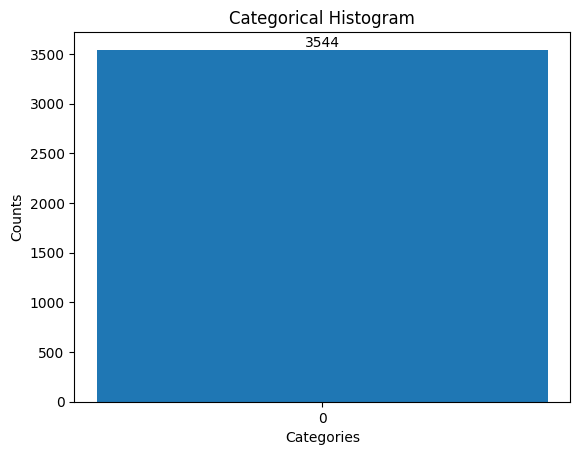

In [12]:
plot_cluster_hist(kmeans.labels_);
# plot_cluster_hist(test_clusters);

#### **Survival Prediction**

In [13]:
class generic_Loss(torch.nn.Module):
    '''
    Generic Loss Function
    '''
    def __init__(self, reduction: str = 'mean') -> None:
        super().__init__()
        self.reduction = reduction

    def nll_logistic_hazard(self , logits , targets , dur_idx):
        '''
        logits - parameterized inv.logit(hazards) from nn
        targets - survival matrix 
        '''
        logits = torch.Tensor(logits)
        targets = torch.Tensor(targets)
        dur_idx = torch.Tensor(dur_idx).to(torch.int64).view(-1 , 1)

        loss = F.binary_cross_entropy_with_logits(input = logits , target = targets , reduction = 'none')
        
        assert loss.shape == targets.shape , 'must match'

        # cumulative hazards
        loss = loss.cumsum(1)
        loss = loss.gather(1, dur_idx)
        
        return loss.view(-1).mean()

In [14]:
class MLP(nn.Module):
    def __init__(self , input_size , hidden_size , output_size , dropout_rate = 0.1):
        super(MLP , self).__init__()

        # Define the dimensions of the RNN
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size

        self.rnn = nn.RNN(self.input_size, self.hidden_size, batch_first=True)
        
        # Feed-forward nn
        self.fc = nn.Sequential( 
            nn.BatchNorm1d(hidden_size), 
            nn.Dropout(dropout_rate),
            nn.Linear(hidden_size , hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, output_size)
        )

    def forward(self, x):
        # Initialize the hidden state
        h0 = torch.zeros(1, x.size(0), self.hidden_size)#.to(x.device)

        # Forward pass through the RNN layer
        out, _ = self.rnn(x, h0)
        
        # Get the output from the last time step
        out = self.fc(out[:, -1, :])

        return out

In [15]:
class MyDataset_MLP(Dataset):
    '''
    simple data set class
    '''
    def __init__(self, features, durations, events):
        self.data = features
        self.durations = durations
        self.events = events
        assert self.data.shape[0] == self.durations.shape[0] == self.events.shape[0] , 'shapes must match!'

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        cov = self.data[index] # covariates
        dur = self.durations[index] # durations
        eve = self.events[index] # events
        return cov , dur , eve

In [16]:
class Surv_Matrix:
    def __init__(self , duration_index , events , q_cuts=10):
        self.duration_index = duration_index
        self.events = events
        self.q_cuts = q_cuts
    
    def make_survival_matrix(self):
        '''
        converts durations and index into a matrix denoting time of event
        this is the y_ij matrix as shown in Kvamme's paper
        '''
        self.surv_matrix = torch.eye(self.q_cuts)[self.duration_index] 
        self.surv_matrix = self.surv_matrix*self.events.reshape(-1 , 1) # censoring mask
        return self.surv_matrix

In [17]:
class Transforms:
    def __init__(self , durations):
        self.durations = durations
        
    def discrete_transform(self , _cuts):
        '''
        cut at even spaces
        '''
        self.bin_edges = np.linspace(self.durations.min() , self.durations.max() , _cuts) # right-side edges of the bins
        self.duration_index = np.searchsorted(a = self.bin_edges , v = self.durations)
        self.n_duration_index = self.duration_index.max()+1
        # print(self.n_duration_index)
        assert self.n_duration_index == _cuts , 'must match'
        return self.duration_index

In [18]:
q_cuts = 15 # number of discretized durations

# Prepare val and test data
get_target = lambda df: (df['time_to_event'].values, df['death'].values)

y_train_dur , y_train_event = get_target(y_train)

y_test_dur , y_test_event = get_target(y_test)
t_test = Transforms(durations = y_test_dur)
dur_idx_test = t_test.discrete_transform(_cuts = q_cuts)

In [19]:
input_size = 90
# fc_input_size = enc_train.shape[1]
hidden_size = 32
output_size = t_test.n_duration_index

# Create a data loader for batching and shuffling
batch_size = 512
num_epochs = 500
learning_rate = 0.001
shuffle = True
patience = 20
dropout = 0.5

# build net(s)
nets = []

# init as many networks as there are clusters
for grp in np.unique(train_clusters):
    # init net
    mlp = MLP(input_size , hidden_size , output_size , dropout_rate = dropout)
    # init optim
    optimizer = torch.optim.Adam(mlp.parameters() , lr = learning_rate)
    # append
    nets.append((mlp , optimizer))

In [20]:
# init loss
l = generic_Loss()

# init loss for early stopping
best_loss = np.Inf

for i , grp in enumerate(np.unique(kmeans.labels_)): 
    print(f'training cluster {i}')
    # get features
    # features = enc_df_train_grouped.get_group(grp)
    features = x_train_reshape_tv[train_clusters == grp]
    # get death time and event indicator
    y_train_dur , y_train_event = get_target(y_train.iloc[kmeans.labels_ == grp , :])

    t_train = Transforms(durations = y_train_dur)
    dur_idx = t_train.discrete_transform(_cuts = q_cuts)
    
    # features = features.iloc[: , :-2].to_numpy() # curtail  features column

    # Create an instance of your custom dataset
    dataset = MyDataset_MLP(features, dur_idx , y_train_event) # need to change outcomes[0] to indexed version
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)

    # Training loop
    for epoch in range(num_epochs):
        for batch_id , (patient_image , dur , eve) in enumerate(dataloader):
            # get mlp and optimizer
            net = nets[i][0]
            optimizer = nets[i][1]

            # Prime for training
            net.train()
            
            # forward pass
            phi_train = net(patient_image)

            # make survival matrix
            sm = Surv_Matrix(duration_index = dur, events = eve , q_cuts = q_cuts)
            surv_mat = sm.make_survival_matrix()        

            # get loss
            loss = l.nll_logistic_hazard(logits = phi_train , targets = surv_mat , dur_idx = dur)

            # backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            # Early stopping
            with torch.no_grad():
                # get duration, event
                y_val_dur , y_val_event = get_target(y_val.iloc[val_clusters == grp , :])
                
                # transform to discrete
                t_val = Transforms(durations = y_val_dur)
                dur_idx_val = t_val.discrete_transform(_cuts = q_cuts)
                
                # build surv matrix for val data
                sm_val = Surv_Matrix(duration_index = dur_idx_val , events = y_val_event , q_cuts = q_cuts)
                surv_mat_val = sm_val.make_survival_matrix()
                
                # compute loss
                phi_val = net(x_val_reshape_tv[val_clusters == grp])
                val_loss = l.nll_logistic_hazard(logits = phi_val, targets = surv_mat_val , dur_idx = dur_idx_val)
            
            # Check if validation loss has improved
            if val_loss < best_loss:
                best_loss = val_loss
                counter = 0
            else:
                counter += 1

            # Check if early stopping condition is met
            if counter >= patience:
                # print(f"Early stopping at epoch {epoch}.")
                break

        if (epoch%50==0): print(f'''Epoch {epoch}: Training Loss: {loss.item():.4f} , Val loss: {val_loss.item():.4f}''') 

training cluster 0
Epoch 0: Training Loss: 2.8985 , Val loss: 2.7917
Epoch 50: Training Loss: 1.0165 , Val loss: 1.0485
Epoch 100: Training Loss: 1.0122 , Val loss: 1.0307
Epoch 150: Training Loss: 0.9620 , Val loss: 1.0333
Epoch 200: Training Loss: 1.0103 , Val loss: 1.0336
Epoch 250: Training Loss: 0.9706 , Val loss: 1.0240
Epoch 300: Training Loss: 1.0183 , Val loss: 1.0214
Epoch 350: Training Loss: 0.9521 , Val loss: 1.0278
Epoch 400: Training Loss: 1.0324 , Val loss: 1.0265
Epoch 450: Training Loss: 0.8989 , Val loss: 1.0331


**Testing**

In [21]:
# Testing
surv = [] # length will be equal to number of cluster
mc_iter = 69

# init empty lists for duration and event 
y_test_dur = []
y_test_event = []

# predict for each cluster
for i , grp in enumerate(np.unique(kmeans.labels_)):
    
    # get features, death time and event indicator
    features = x_test_reshape_tv[test_clusters == grp]
    
    # get death time and event indicator
    y_test_dur_ , y_test_event_ = get_target(y_test.iloc[val_clusters == grp , :])
    y_test_dur.append(y_test_dur_)
    y_test_event.append(y_test_event_)

    survival = []

    # apply Monte Carlo dropout
    for _ in range(mc_iter):
        net = nets[i][0]
        
        # Prime dropout layers
        net.train()
        
        # predict
        mc_haz = torch.sigmoid(net(features))
        mc_survival = torch.log(1 - mc_haz).cumsum(1).exp().detach().numpy()
        
        # append survivals from different runs
        survival.append(mc_survival)
    
    # convert to 3d array
    survival = np.array(survival)
    
    surv.append(survival)

# Concatenate durations and event indicators 
y_test_dur = np.concatenate(y_test_dur , axis = 0)
y_test_event = np.concatenate(y_test_event , axis = 0)

# QCs
assert len(surv) == _clusters , 'surv matrix not matching number of clusters'
assert len(enc_test) == np.sum([surv[k].shape[1] for k in range(_clusters)]) , 'test set count mismatch'

mean_ = np.concatenate([surv[k].mean(axis = 0) for k in range(_clusters)])
up_ = np.concatenate([np.quantile(surv[k] , axis = 0 , q = 0.95) for k in range(_clusters)])
low_ = np.concatenate([np.quantile(surv[k] , axis = 0 , q = 0.05) for k in range(_clusters)])

# QCs
assert mean_.shape[0] == up_.shape[0] == low_.shape[0] == y_test_dur.shape[0] == y_test_event.shape[0] , 'shape mismatch'

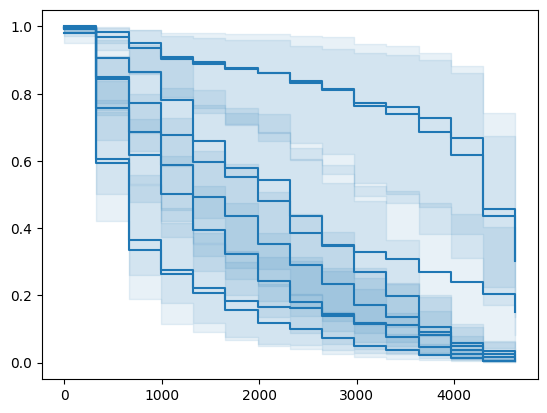

In [22]:
def plot_with_cf(mean_ , low_ , up_ , _from , _to = None):
    if _to is not None:
        for _ , (m , l , u) in enumerate(zip(mean_[_from:_to] , low_[_from:_to] , up_[_from:_to])):
            plt.step(t_test.bin_edges , m , where = 'post' , label = 'mean' , color = 'C0');
            plt.fill_between(t_test.bin_edges , l , u , step = 'post' , alpha = 0.1 , label = 'confint' , color = 'C0');
    else:
        m , l , u = mean_[_from] , low_[_from] , up_[_from]
        plt.step(t_test.bin_edges , m , where = 'post' , label = 'mean' , color = 'C0');
        plt.fill_between(t_test.bin_edges , l , u , step = 'post' , alpha = 0.1 , label = 'confint' , color = 'C0');

plot_with_cf(mean_ , low_ , up_ , _from = 2 , _to = 10)

shapes : (1180, 1180, 1180, 1180)
concordance-td: 0.7026760802581459
integrated brier score 0.31411124106925276


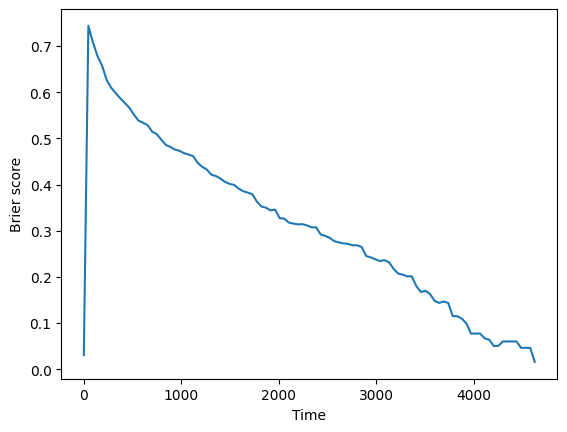

In [23]:
# Evaluation

ev_ = EvalSurv(pd.DataFrame(mean_.T) , y_test_dur , y_test_event , censor_surv='km')
print(f'concordance-td: {ev_.concordance_td()}')

time_grid = np.linspace(y_test_dur.min(), y_test_dur.max(), 100)
ev_.brier_score(time_grid).plot()
plt.ylabel('Brier score')
_ = plt.xlabel('Time')

print(f'integrated brier score {ev_.integrated_brier_score(time_grid) }')

## **Explainer**

In [59]:
# SHAP Values
grp = 1

background = x_train_grouped.get_group(grp)
background = torch.Tensor(background.iloc[: , :-2].to_numpy()) # curtail  features column

testing_data = x_test_grouped.get_group(grp)
testing_data = torch.Tensor(testing_data.iloc[: , :-2].to_numpy()) # curtail  features column

explainer = shap.DeepExplainer(nets[i][0] , background)
shap_values = explainer.shap_values(testing_data)

Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.


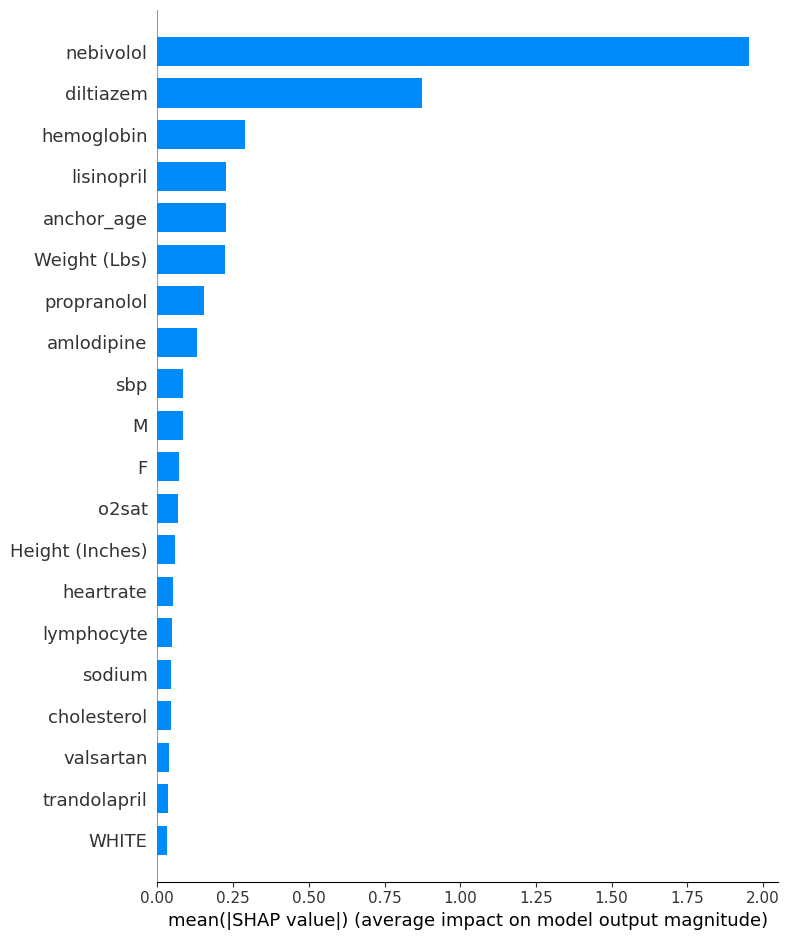

In [60]:
shap.summary_plot(shap_values[0], plot_type = 'bar', feature_names = x_test_grouped.get_group(grp).iloc[: , :-2].columns)

In [61]:
shap.initjs()
shap.force_plot(explainer.expected_value[0], shap_values[0][0], features = x_test_grouped.get_group(grp).iloc[: , :-2].columns)

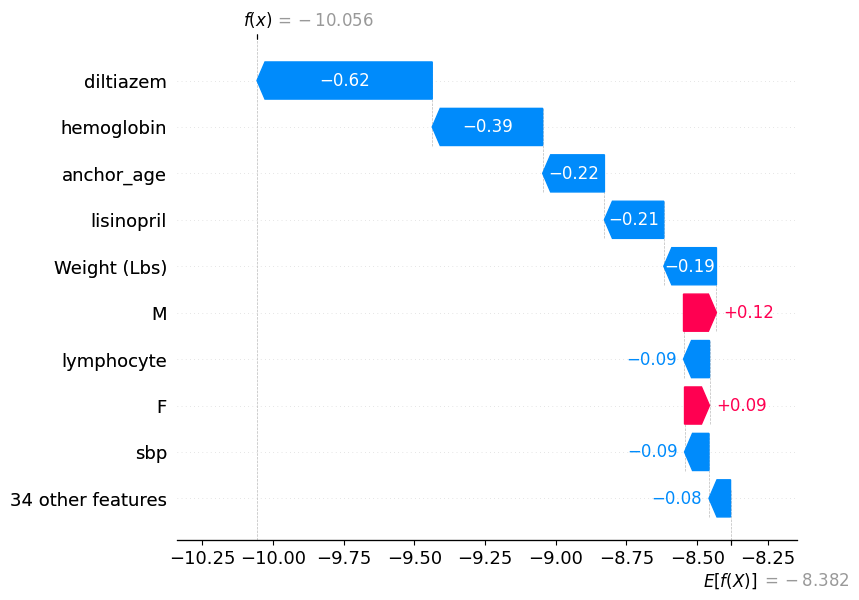

In [62]:
shap.plots._waterfall.waterfall_legacy(explainer.expected_value[0], shap_values[0][0], 
                                       feature_names = x_test_grouped.get_group(grp).iloc[: , :-2].columns)

-----------------

## **JUNK**

In [ ]:
# # Define the RNN Autoencoder model
# class RNN_AE(nn.Module):
#     def __init__(self, input_size, hidden_size, bottleneck_size):
#         super(RNN_AE, self).__init__()
#         self.hidden_size = hidden_size
        
#         # RNN Encoder
#         self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
        
#         # Bottleneck layer
#         self.encoder = nn.Linear(hidden_size, bottleneck_size)
        
#         # Autoencoder Decoder
#         self.decoder = nn.Sequential(
#             nn.Linear(bottleneck_size, hidden_size),
#             nn.ReLU(),
#             nn.Linear(hidden_size, input_size)
#         )

#     def forward(self, x):
#         # RNN Encoder
#         rnn_output, _ = self.rnn(x)
        
#         # Bottleneck Layer
#         encoded_output = self.encoder(rnn_output)
        
#         # Autoencoder Decoder
#         decoded_output = self.decoder(encoded_output)
        
#         return encoded_output , decoded_output

In [ ]:
# input_size = 91
# hidden_size = 100
# bottleneck_size = 46

# # Model Initialization
# model = RNN_AE(input_size, hidden_size, bottleneck_size)
 
# # Validation using MSE Loss function
# loss_function = torch.nn.MSELoss()
 
# # Using an Adam Optimizer with lr = 0.1
# optimizer = torch.optim.Adam(model.parameters(),
#                              lr = 1e-1,
#                              weight_decay = 1e-8)

In [ ]:
# enc , dec = model(torch.Tensor(x_train_reshape_tv[1000]))
# enc.shape , dec.shape

(torch.Size([122, 46]), torch.Size([122, 91]))

In [ ]:
# # # %%time

# # # # def get_spca(L , M , k):
# # # #     # normalize
# # # #     L_ = L/np.linalg.norm(L , axis = 0)
# # # #     M_ = M/np.linalg.norm(M , axis = 0)
# # # #     # get spca
# # # #     s_pca = np.trace(L_@M_.T@M_@L_.T)/k
# # # #     return s_pca

# # # # pca_transforms = []
# # # # n_components = 1

# # # # for idx , x in enumerate(x_train_reshape_tv):
# # # #     pca = PCA(n_components = n_components , svd_solver = 'arpack') # encourage sparse solutions
# # # #     pca_transform_x = pca.fit_transform(x)
# # # #     # store in list
# # # #     pca_transforms.append(pca_transform_x)
# # # # # form an array (optional)
# # # # pca_transforms_arr = np.array(pca_transforms , dtype = 'object')

# # # # assert len(pca_transforms_arr) == len(x_train_reshape_tv) , 'lengths must match'

# # # # # Create a square distance matrix
# # # # distance_matrix = np.zeros((len(pca_transforms_arr) , len(pca_transforms_arr)))

# # # # for i in range(len(pca_transforms_arr)):
# # # #     for j in range(i , len(pca_transforms_arr)):
# # # #         distance_matrix[i,j] = get_spca(L = pca_transforms_arr[i] , M = pca_transforms_arr[j] , k = n_components)
# # # #         distance_matrix[j,i] = distance_matrix[i,j]

# # # # L = np.random.randn(3,3)
# # # # M = np.random.randn(40,3)
# # # # get_spca(L , M , 5)
# # # pca.components_

# # import pickle
# # # Pickle the DataFrame
# # with open('data/distance_matrix_train_.pickle', 'wb') as file:
# #     pickle.dump(distance_matrix, file)
# # Read the pickled DataFrames
# with open('data/distance_matrix_train_.pickle', 'rb') as file:
#     distance_matrix_train_ = pickle.load(file)